In [6]:
# Libraries Used
import tensorflow as tf
from library import hrNet
import numpy as np
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_windows
# The following functions were imported from code from public GitHub repos. The URL for the source code 
# can be found in the code files
from yuv420 import readYUV420, readYUV420Range, writeYUV420
from rgb2yuv_yuv2rgb import YUV2RGB, RGB2YUV
from auxFunctions import image_preprocess, readFrames, createOverlappingPatches, selectPatches

In [2]:
# To Set up the LPIPS metric
import lpips
import torch
class lpipsClass():
    def __init__(self):
        self.loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

    def lpipsLossFunc(self, x, y):
        x, y = torch.tensor(x), torch.tensor(y)
        d = self.loss_fn_vgg(x, y)
        return d

Proposed Idea for the Video Processing Algorithm - Computes LPIPS for a range of restored frames

In [9]:
# Video Restoration Algorithm

# Loop through the frames of a video
# for now, I specify the number of frames which can be less than the max number of frames of a video
# The 'RUST_0.yuv' video has resolution of (1920,1080), and number of frames = 300

vidFilePath = 'Dataset/'
vidFileName = 'DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3_AV1_CRF13_.yuv'
vidResolution = (1920,1080)
vidNumFrames = 116


vidLPIPS = np.zeros(vidNumFrames)

# The artifact removal deep network hrNet model
artifactReductionModel = hrNet(2, [32, 64, 128, 256], 5).model()
# Loads in the current weights, will be changed later after training on dataset
artifactReductionModel.load_weights('modelWeights/287_HRNET.h5')

# Creates an instance of LPIPS
lpipsInst = lpipsClass()

restoredY = np.zeros((1,vidResolution[1],vidResolution[0]))
restoredU = np.zeros((1,vidResolution[1],vidResolution[0]))
restoredV = np.zeros((1,vidResolution[1],vidResolution[0]))

# Need to fix the ranges, issues with t-1 and t+1
for t in range(113,vidNumFrames):
    print("\nFrame Number: ",t)
    # For each frame at frame number t, read in the previous and next frame aswell
    frame_tmin1,frame_t,frame_tplus1 = readFrames(vidFilePath+vidFileName,vidResolution,t,vidNumFrames)

    # The frames are padded with additional pixel values - for now the padding is only tested with resolution -> (1920,1080)
    frame_tmin1_pad = np.pad(frame_tmin1,((36,36),(0,0),(0,0)), mode='symmetric')
    frame_t_pad = np.pad(frame_t,((36,36),(0,0),(0,0)), mode='symmetric')
    frame_tplus1_pad = np.pad(frame_tplus1,((36,36),(0,0),(0,0)), mode='symmetric')

    # For now the windows/patches don't currently overlap due to the specified stepsize - will work on this later
    Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1 = createOverlappingPatches(frame_tmin1_pad)
    Rwindow_t,Gwindow_t,Bwindow_t = createOverlappingPatches(frame_t_pad)
    Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1 = createOverlappingPatches(frame_tplus1_pad)

    # The amount of patches in a column and row respectively
    numPatchesY = Gwindow_t[:,1,1,1].size
    numPatchesX = Gwindow_t[1,:,1,1].size

    # Loop through the windows to select patches and retrieve the hrNet model output for the patches
    rowPatches = np.zeros((1,192,192,3))
    restoredFrame = np.zeros((1,192,1920,3))

    # moving across a row of patches, and then down to next row - to build a restored frame
    for j in range(numPatchesY):
        for i in range(numPatchesX):
            patch_tmin1 = selectPatches(Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1,j,i)
            patch_t = selectPatches(Rwindow_t,Gwindow_t,Bwindow_t,j,i)
            patch_tplus1 = selectPatches(Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1,j,i)

            inputPatches = np.concatenate((patch_tmin1, patch_t, patch_tplus1), axis=-1)
            inputPatches = np.expand_dims(inputPatches, axis=0)
            inputPatches = tf.convert_to_tensor(inputPatches)
            outputPatch = artifactReductionModel(inputPatches, training=False)
            
            if i == 0:
                rowPatches = np.copy(outputPatch)
            else:
                rowPatches = np.concatenate((rowPatches,outputPatch),axis=2)

        if j == 0:
            restoredFrame = np.copy(rowPatches)
        else:
            restoredFrame = np.concatenate((restoredFrame,rowPatches),axis=1)

    # crop the padded output frame back to the correct resolution (assumes for now resolution is (1920,1080))
    outputFrame = np.copy(restoredFrame[:,36:1080+36, :,:])

    # building the video from the frames
    outputFrameYUV = RGB2YUV(outputFrame[0])
    Yout = outputFrameYUV[:,:,0]
    Yout = np.expand_dims(Yout,axis=0)
    Uout = outputFrameYUV[:,:,1]
    Uout = np.expand_dims(Uout,axis=0)
    Vout = outputFrameYUV[:,:,2]
    Vout = np.expand_dims(Vout,axis=0)
    
    if t == 113:
        restoredY  = np.copy(Yout)
        restoredU  = np.copy(Uout)
        restoredV  = np.copy(Vout)
    else:
        restoredY = np.concatenate((restoredY,Yout))
        restoredU = np.concatenate((restoredU,Uout))
        restoredV = np.concatenate((restoredV,Vout))

    # Some additional image processing required for use with LPIPS
        # the original frame - convert 
    img0 = image_preprocess(frame_t)
    img0 = np.expand_dims(img0,axis=0)
    img0 = np.moveaxis(img0,-1,1)
        # the restored frame
    img1 = image_preprocess(outputFrame)
    img1 = np.moveaxis(img1,-1,1)
        # Converting from numpy to pytorch
    img0 = np.float32(img0)
    img0 = torch.tensor(img0)
    img1 = torch.tensor(img1)

    # Outputs the LPIPS metric evaluation for the original frame t and the restored frame (the two inputs)
    dist = lpipsInst.lpipsLossFunc(img0, img1)
    vidLPIPS[t] = dist.item()
    print("\nLPIPS: ", dist.item())
# calculate the mean of the lpips array
LPIPS_avg = vidLPIPS.mean()
print("Average LPIPS: ",LPIPS_avg)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\lpips\weights\v0.1\vgg.pth

Frame Number:  113


C:\Users\victo\AppData\Local\Temp\ipykernel_17184\3970268432.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)



LPIPS:  9.606851563148666e-07

Frame Number:  114

LPIPS:  1.0114365522895241e-06

Frame Number:  115

LPIPS:  9.701416274765506e-07
Average LPIPS:  2.5364339104146046e-08


In [24]:
# Implement saving the restored frames a video
writeYUV420("Dataset/DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3_AV1_CRF13_hrNet.yuv",np.uint8(restoredY),np.uint8(restoredU),np.uint8(restoredV),downsample=True)

In [14]:
# Not very good, but just to crop the original to be similar to restored frame
ytest,utest, vtest= readYUV420Range("Dataset/DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3.yuv",(1920,1080),(113,115),upsampleUV=True)
writeYUV420("Dataset/DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3_cropped.yuv",np.uint8(ytest),np.uint8(utest),np.uint8(vtest),downsample=True)

The Video Processing Algorithm that computes the LPIPS metric between one restored and original frame

In [25]:
vidFilePath = 'Dataset/'
vidFileName = 'DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3_AV1_CRF13_.yuv'
vidResolution = (1920,1080)
vidNumFrames = 120

frame_tmin1,frame_t,frame_tplus1 = readFrames(vidFilePath+vidFileName,vidResolution,113,vidNumFrames)

frame_tmin1_pad = np.pad(frame_tmin1,((36,36),(0,0),(0,0)), mode='symmetric')
frame_t_pad = np.pad(frame_t,((36,36),(0,0),(0,0)), mode='symmetric')
frame_tplus1_pad = np.pad(frame_tplus1,((36,36),(0,0),(0,0)), mode='symmetric')

# Function to return the RGB windows for a frame
Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1 = createOverlappingPatches(frame_tmin1_pad)
Rwindow_t,Gwindow_t,Bwindow_t = createOverlappingPatches(frame_t_pad)
Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1 = createOverlappingPatches(frame_tplus1_pad)

max_y = Gwindow_t[:,1,1,1].size
max_x = Gwindow_t[1,:,1,1].size
artifactReductionModel = hrNet(2, [32, 64, 128, 256], 5).model()
artifactReductionModel.load_weights('modelWeights/287_HRNET.h5')

In [26]:
# Selecting the patches from the window - takes about 2 min to run on my laptop
rowPatches = np.zeros((1,192,192,3))
restoredFrame = np.zeros((1,192,vidResolution[0],3))
for j in range(max_y):
    for i in range(max_x):
        patch_tmin1 = selectPatches(Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1,j,i)
        patch_t = selectPatches(Rwindow_t,Gwindow_t,Bwindow_t,j,i)
        patch_tplus1 = selectPatches(Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1,j,i)

        inputPatches = np.concatenate((patch_tmin1, patch_t, patch_tplus1), axis=-1)
        inputPatches = np.expand_dims(inputPatches, axis=0)
        inputPatches = tf.convert_to_tensor(inputPatches)
        outputPatch = artifactReductionModel(inputPatches, training=False)

        if i == 0:
            rowPatches = np.copy(outputPatch)
        else:
            rowPatches = np.concatenate((rowPatches,outputPatch),axis=2)

    if j == 0:
        restoredFrame = np.copy(rowPatches)
    else:
        restoredFrame = np.concatenate((restoredFrame,rowPatches),axis=1)

outputFrame = np.copy(restoredFrame[:,36:1080+36, :,:])

In [8]:
print(outputFrame.shape)

(1, 1080, 1920, 3)


In [25]:
restoredY = np.zeros((1,vidResolution[1],vidResolution[0]))
restoredU = np.zeros((1,vidResolution[1],vidResolution[0]))
restoredV = np.zeros((1,vidResolution[1],vidResolution[0]))

In [10]:
# Testing the building of a video from frames
outputFrameYUV = RGB2YUV(outputFrame[0])
Yout = outputFrameYUV[:,:,0]
Yout = np.expand_dims(Yout,axis=0)
Uout = outputFrameYUV[:,:,1]
Uout = np.expand_dims(Uout,axis=0)
Vout = outputFrameYUV[:,:,2]
Vout = np.expand_dims(Vout,axis=0)

In [29]:
restoredY  = np.copy(Yout)
print(restoredY.shape)

(1, 1080, 1920)


In [30]:
restoredY = np.concatenate((restoredY,Yout))
print(restoredY.shape)

(2, 1080, 1920)


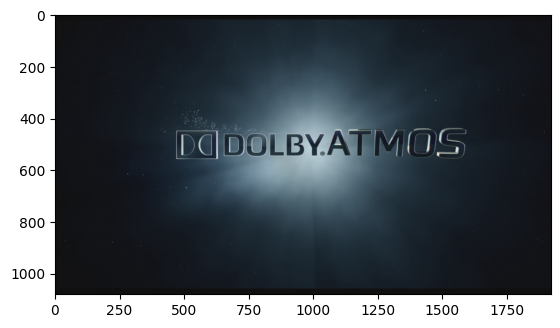

In [27]:
# The Restored Frame
toShow = np.uint8(outputFrame[0,:,:,:])
plt.imshow(toShow)

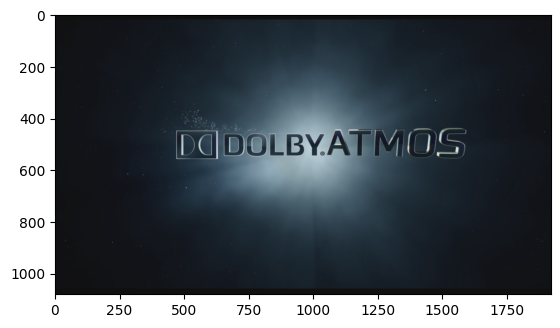

In [28]:
# The Original Frame
toShow = np.uint8(frame_t[:,:,:])
plt.imshow(toShow)

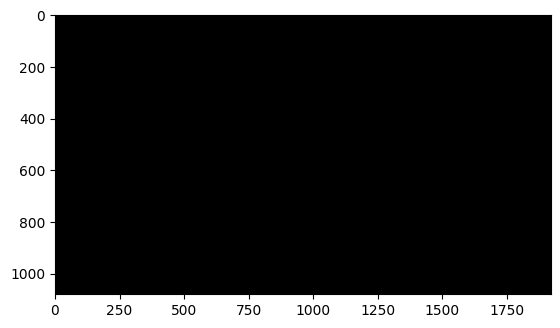

In [29]:
# The Difference Frame
difference_frame = np.absolute(np.subtract(outputFrame[0],frame_t))
plt.imshow(np.uint8(difference_frame[:,:,:]))

In [30]:
# Some image processing required to compute LPIPS (which uses Pytorch)
# the original frame
img0 = image_preprocess(frame_t)
img0 = np.expand_dims(img0,axis=0)
img0 = np.moveaxis(img0,-1,1)
img0 = np.float32(img0)
# the restored frame
img1 = image_preprocess(outputFrame)
img1 = np.moveaxis(img1,-1,1)
# Converting from numpy to pytorch
img0 = torch.tensor(img0)
img1 = torch.tensor(img1)

In [31]:
# Creates an instance of LPIPS
lpipsInst = lpipsClass()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [32]:
#Outputs the LPIPS metric evaluation for the original frame t and the restored frame (the two inputs)
dist = lpipsInst.lpipsLossFunc(img0, img1)
print(dist.item())

C:\Users\victo\AppData\Local\Temp\ipykernel_17184\3970268432.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)


9.606851563148666e-07


Trying to implement the Overlap and Add Method

In [ ]:
vidFilePath = 'Dataset/'
vidFileName = 'Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-thedigitaltheater_19_H265_CRF1_.yuv'
vidResolution = (1920,1080)
vidNumFrames = 120

frame_tmin1,frame_t,frame_tplus1 = readFrames(vidFilePath+vidFileName,vidResolution,85,vidNumFrames)

frame_tmin1_pad = np.pad(frame_tmin1,((36,36),(0,0),(0,0)), mode='symmetric')
frame_t_pad = np.pad(frame_t,((36,36),(0,0),(0,0)), mode='symmetric')
frame_tplus1_pad = np.pad(frame_tplus1,((36,36),(0,0),(0,0)), mode='symmetric')

# Function to return the RGB windows for a frame
#Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1 = createOverlappingPatches(frame_tmin1_pad)
#Rwindow_t,Gwindow_t,Bwindow_t = createOverlappingPatches(frame_t_pad)
#Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1 = createOverlappingPatches(frame_tplus1_pad)

max_y = Gwindow_t[:,1,1,1].size
max_x = Gwindow_t[1,:,1,1].size
artifactReductionModel = hrNet(2, [32, 64, 128, 256], 5).model()
artifactReductionModel.load_weights('modelWeights/287_HRNET.h5')

In [18]:
print(1152/96)

12.0


In [16]:
for j in range(0,1152/96):
    for i in range(0,1080/96):
        pass
        # patch tmin1 = frame_tmin1_pad[0+j*192:192+j*192,0+j*192:192+j*192,:]
        # patch t
        # path t plus 1
        # preparation as input patches and then receive an outputPatch
        # since its in the same loop, 

6.0


In [21]:
zeros = np.zeros((270,270))
ones = np.ones((150,150))

In [23]:
zeros[0:150,0:150] = ones

In [ ]:
rowPatches = np.zeros((1,192,192,3))
restoredFrame = np.zeros((1,192,vidResolution[0],3))
for j in range(max_y):
    for i in range(max_x):
        patch_tmin1 = selectPatches(Rwindow_tmin1,Gwindow_tmin1,Bwindow_tmin1,j,i)
        patch_t = selectPatches(Rwindow_t,Gwindow_t,Bwindow_t,j,i)
        patch_tplus1 = selectPatches(Rwindow_tplus1,Gwindow_tplus1,Bwindow_tplus1,j,i)

        inputPatches = np.concatenate((patch_tmin1, patch_t, patch_tplus1), axis=-1)
        inputPatches = np.expand_dims(inputPatches, axis=0)
        inputPatches = tf.convert_to_tensor(inputPatches)
        outputPatch = artifactReductionModel(inputPatches, training=False)

        if i == 0:
            rowPatches = np.copy(outputPatch)
        else:
            rowPatches = np.concatenate((rowPatches,outputPatch),axis=2)

    if j == 0:
        restoredFrame = np.copy(rowPatches)
    else:
        restoredFrame = np.concatenate((restoredFrame,rowPatches),axis=1)

outputFrame = np.copy(restoredFrame[:,36:1080+36, :,:])